# Выбор локации для скважины

Компании нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Цель: постройть модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import os
import warnings
import re
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
pth1 = '/datasets/geo_data_0.csv'
pth2 = '/datasets/geo_data_1.csv'
pth3 = '/datasets/geo_data_2.csv'



if os.path.exists(pth1):
    geo_1 = pd.read_csv(pth1)
else:
    print('Something is wrong')
    
if os.path.exists(pth2):
    geo_2 = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
if os.path.exists(pth3):
    geo_3 = pd.read_csv(pth3)
else:
    print('Something is wrong')
    

In [5]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_1.head(3)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


In [9]:
geo_2.head(3)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


In [10]:
geo_3.head(3)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


Данные соотвествуют описанию задачи. Во всех трех датафреймах по 100000 объектов.

In [11]:
#Проверим наличие пропусков 
dates = [geo_1, geo_2, geo_3]
for data in dates:
    print(f'Пропуски: {data.isna().sum()}')
    print()

Пропуски: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропуски: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропуски: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



In [12]:
#Проверим наличие явных дубликатов
print(f'Явных дубликатов в market_data: {geo_1.duplicated().sum()}')
print(f'Явных дубликатов в market_money_data: {geo_2.duplicated().sum()}')
print(f'Явных дубликатов в time_data: {geo_3.duplicated().sum()}')


Явных дубликатов в market_data: 0
Явных дубликатов в market_money_data: 0
Явных дубликатов в time_data: 0


In [13]:
#Проверим наличие неявных дубликатов
print(f'Количество уникальных значений id в geo_1: {geo_1["id"].nunique()}')
print(f'Количество уникальных значений id в geo_2: {geo_2["id"].nunique()}')
print(f'Количество уникальных значений id в geo_3: {geo_3["id"].nunique()}')

Количество уникальных значений id в geo_1: 99990
Количество уникальных значений id в geo_2: 99996
Количество уникальных значений id в geo_3: 99996


Данные находятся в нужным типах. Пропущенных значений нет, дубликатов нет. Данные готовы для дальнейшей обработки.

In [14]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


- Первый признак: среднее значение и медиана - 0.5
- Второй признак: среднее значение и медиана - 0.25
- Третий признак: среднее значение - 2.50, медиана - 2.52
- Объем запасов: среднее значение - 91.8, медиана - 92.5

In [15]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


- Первый признак: среднее значение и медиана - 1.1
- Второй признак: среднее значение и медиана - -4.8
- Третий признак: среднее значение - 2.5, медиана - 2.0
- Объем запасов: среднее значение - 68.8, медиана - 57.1

In [16]:
geo_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


- Первый признак: среднее значение и медиана - 0
- Второй признак: среднее значение и медиана - 0
- Третий признак: среднее значение - 2.50, медиана - 2.48
- Объем запасов: среднее значение - 95.0, медиана - 94.9

In [17]:
#Найдем общую сумму запасов в каждом регионе
print(f'Общие запасы нефти в первом регионе: {geo_1["product"].sum():.0f}')
print(f'Общие запасы нефти во втором регионе: {geo_2["product"].sum():.0f}')
print(f'Общие запасы нефти в третьем регионе: {geo_3["product"].sum():.0f}')

Общие запасы нефти в первом регионе: 9250000
Общие запасы нефти во втором регионе: 6882500
Общие запасы нефти в третьем регионе: 9500000


Больше всего запасов в третьем регионе - 9500000 тыс. баррелей, меньше всего во втором - 6882500 тыс.баррелей.

In [18]:
cols = ['f0', 'f1', 'f2']

In [19]:
#создадим функцию которая строит распределеиня признаков для каждого региона
def distribution_plot(data, cols):
    for col in cols:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
        sns.histplot(data=data, x=col, ax=ax[0])
        ax[0].set_title(f'Расспределение значений столбца "{col}"')
        ax[0].set_xlabel(col)
        ax[0].set_ylabel('Количество значений')
        ax[0].grid(True)
    
        sns.boxplot(data=data, x=col, ax=ax[1])
        ax[1].set_title(f'Диаграмма размаха столбца "{col}"')
        ax[1].set_xlabel(col)

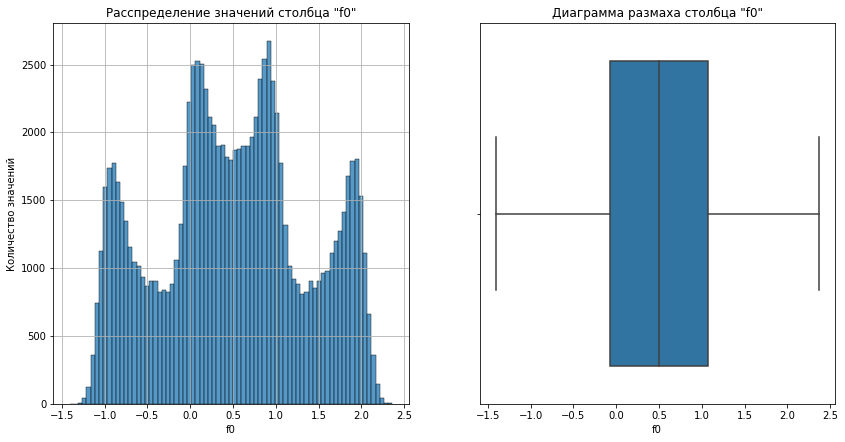

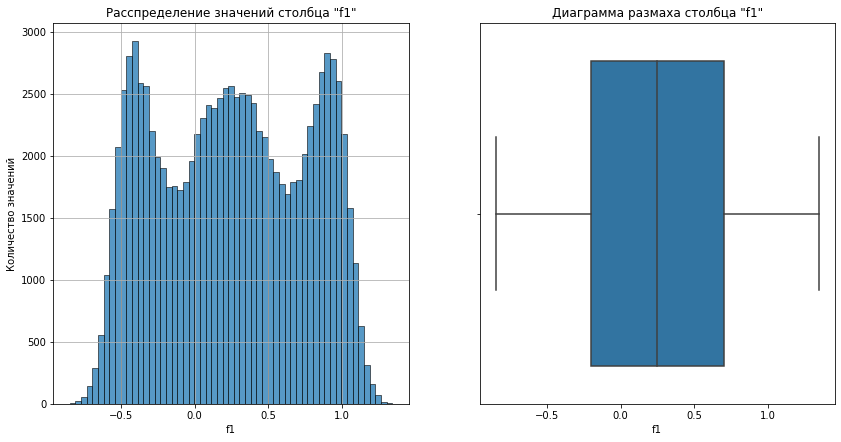

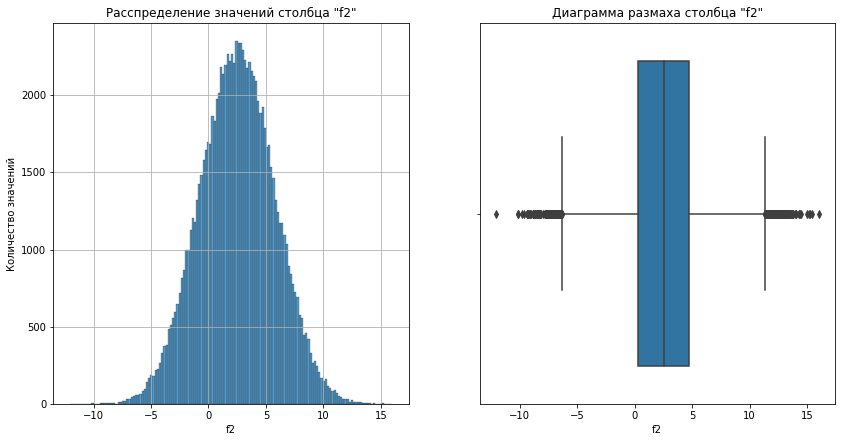

In [20]:
#распределение признаков для geo_1
distribution_plot(geo_1, cols)

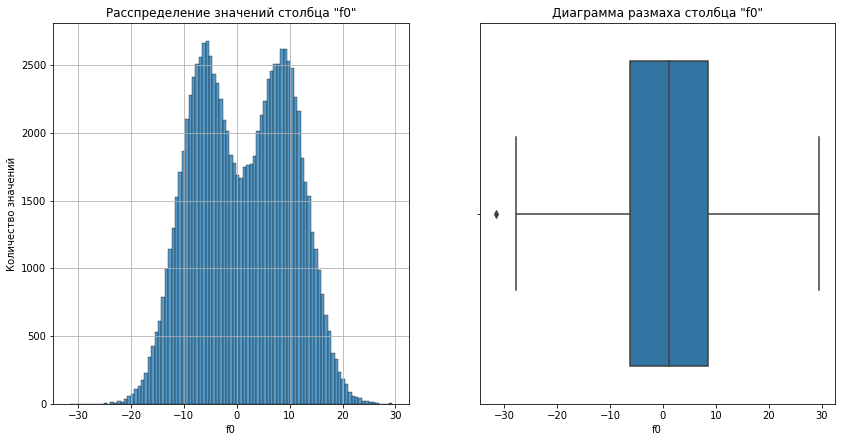

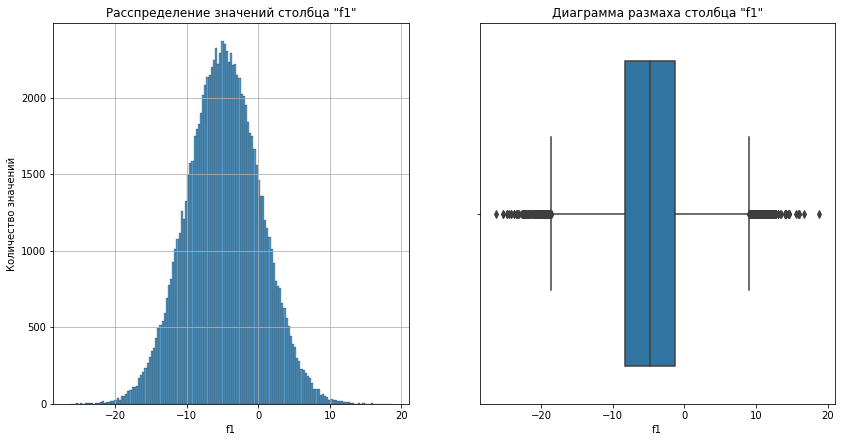

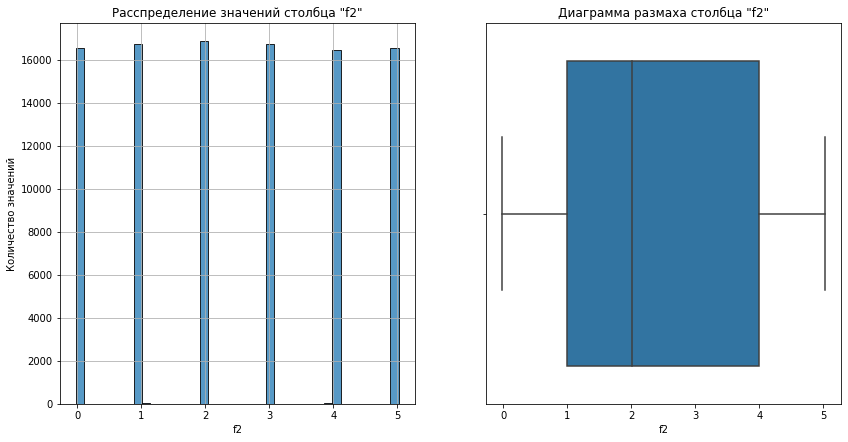

In [21]:
#распределение признаков для geo_2
distribution_plot(geo_2, cols)

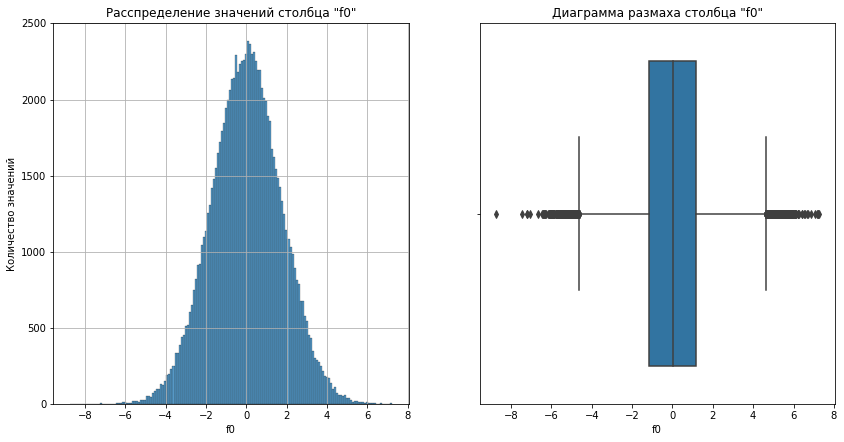

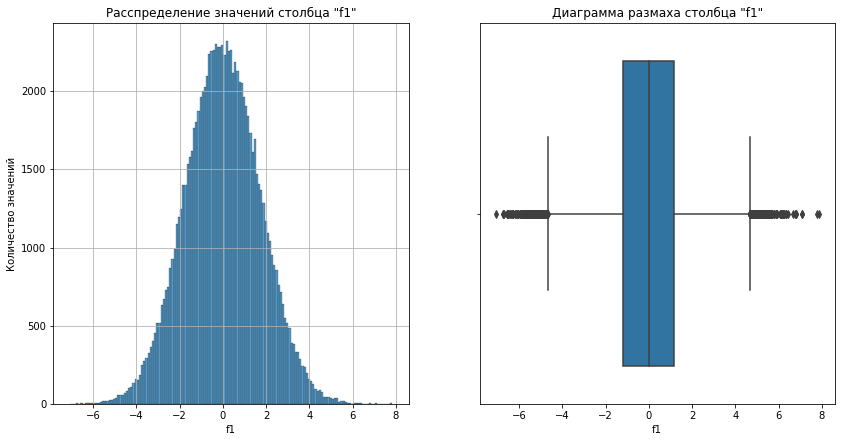

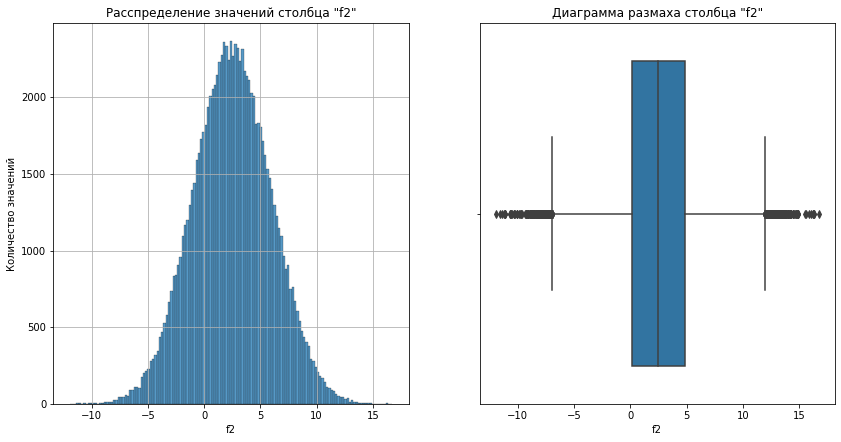

In [22]:
#распределение признаков для geo_3
distribution_plot(geo_3, cols)

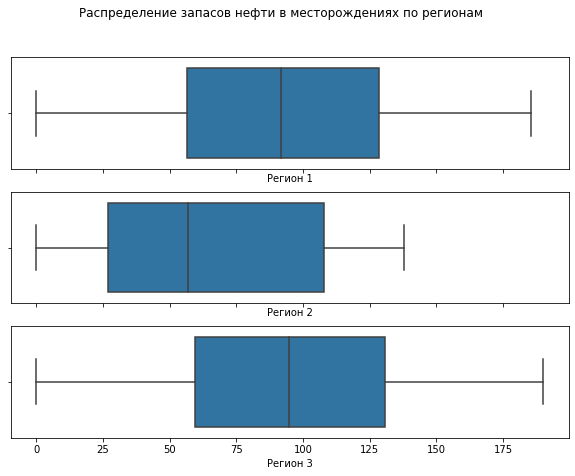

In [23]:
#Построим распределение таргета для каждого региона
fig, axes = plt.subplots(3,1, sharex=True, figsize=(10,7))
sns.boxplot(geo_1['product'], ax=axes[0])
sns.boxplot(geo_2['product'], ax=axes[1])
sns.boxplot(geo_3['product'], ax=axes[2])
axes[0].set_xlabel('Регион 1')
axes[1].set_xlabel('Регион 2')
axes[2].set_xlabel('Регион 3')

fig.suptitle('Распределение запасов нефти в месторождениях по регионам')
plt.show()

Данные подготовлены к дальнейшей работе: дубликатов и пропусков нет. Был проведен исследовательский анализ данных и построены графики распределений признаков. Большей всего запасов нефти в 1 и 3 регионах.

Проведем дополнительный анализ, чтобы объяснить распределение признака f2.

Text(0.5, 1.0, 'График зависимости таргера от "f2"')

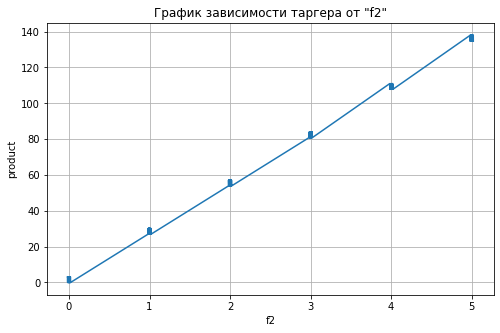

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x='f2', y='product', data=geo_2)
ax.grid(True)
ax.set_title(f'График зависимости таргера от "f2"')

In [25]:
print(f'Коэффициент корреляции Пирсона: {geo_2["product"].corr(geo_2["f2"], method="pearson")}')

Коэффициент корреляции Пирсона: 0.9993969704906553


Выявлена высокая корреляция между целевым признаком и признаков f2.

## Обучение и проверка модели

In [26]:
# список предсказаний по объёму сырья в скважине на валидационной выборке
pred_valid = []

# список правильных ответов на валидационной выборке
valid_target = []

In [27]:
#создадим функцию которая будет разбивать наши данные на обучающую и валидационную выборки в соотношении 75:25 и обучать модель
def model_fitting(data):
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(
        features,
        target,
        test_size=TEST_SIZE,
        random_state = RANDOM_STATE,
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)

    mean_stock = pred.mean()
    rmse = (mean_squared_error(y_valid, pred))**0.5
    
    pred_valid.append(pred)
    valid_target.append(y_valid.reset_index(drop=True))
    
    #return mean_stock, rmse
    print(f'Средний запас предсказанного сырья: {mean_stock:.2f}')
    print(f'RMSE модели: {rmse:.2f}')
    

In [28]:
#модель для первого региона
model_fitting(geo_1)

Средний запас предсказанного сырья: 92.40
RMSE модели: 37.76


In [29]:
#модель для второго региона
model_fitting(geo_2)

Средний запас предсказанного сырья: 68.71
RMSE модели: 0.89


In [30]:
#модель для третьего региона
model_fitting(geo_3)

Средний запас предсказанного сырья: 94.77
RMSE модели: 40.15


In [31]:
pred_valid[0].shape

(25000,)

Регионы с самыми большими запасами также остались 1 и 3, однако у них достаточно большие ошибки. Во втором регионе запасов значительно меньше, но и среднеквадратичная ошибка меньше.

## Подготовка к расчёту прибыли

In [32]:
BUDGET = 10000000000
PRICE_PER_PRODUCT = 450000
NUM_SITES = 500
BEST_SITES = 200

In [33]:
#рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
mean_volume = BUDGET / BEST_SITES / PRICE_PER_PRODUCT
print(f'Достаточный средний объем сырья для одной новой скажины: {mean_volume:.2f} тыс. баррель')

Достаточный средний объем сырья для одной новой скажины: 111.11 тыс. баррель


Достаточный средний объем сырья для одной новой скажины: 111.11 тыс. баррель. Ни в одном регионе нет такого среднего показателя, но в предыдущем учитывались все месторождения, а заказчик просит найти только 200 лучших.

## Расчёт прибыли и рисков 

In [34]:
#создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
def profit(y, pred):
    pred_sorted = pred.sort_values(ascending=False)
    best_spots = y[pred_sorted.index][:BEST_SITES]
    return round(best_spots.sum() * PRICE_PER_PRODUCT - BUDGET)

In [35]:
#прибыль для первого реигона
print(f'Прибыль первого региона: {profit(valid_target[0], pd.Series(pred_valid[0]))}')

Прибыль первого региона: 3359141114


In [36]:
#прибыль для второго реигона
print(f'Прибыль второго региона: {profit(valid_target[1], pd.Series(pred_valid[1]))}')

Прибыль второго региона: 2415086697


In [37]:
#прибыль для третьего реигона
print(f'Прибыль второго региона: {profit(valid_target[2], pd.Series(pred_valid[2]))}')

Прибыль второго региона: 2598571759


Все три региона потенциально прибыльные, но для нахождения наиболее выгодного просчитаем риски каждого региона.

In [38]:
state = RandomState(12345)
def bootstrap(target, prob, region):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        prob_subsample = prob[target_subsample.index]
        target_subsample = target_subsample.reset_index(drop=True)
        prob_subsample = pd.Series(prob_subsample)
        prob_subsample = prob_subsample.reset_index(drop=True)
        
        values.append(profit(target_subsample, prob_subsample))
    
    values = pd.Series(values)
    mean_profit = values.mean()
    interval = (round(values.quantile(0.025)), round(values.quantile(0.975)))
    risk = (values < 0).mean()
    
    print(f'Средняя прибыль для {region} региона: {mean_profit:.0f}') 
    print(f'95%-й доверительный интервал для {region} региона: {interval}')
    print(f'Риск убытков для {region} региона: {risk:.2%}')
    print('\n')

In [39]:
bootstrap(valid_target[0], pd.Series(pred_valid[0]), 1)
bootstrap(valid_target[1], pd.Series(pred_valid[1]), 2)
bootstrap(valid_target[2], pd.Series(pred_valid[2]), 3)

Средняя прибыль для 1 региона: 406278783
95%-й доверительный интервал для 1 региона: (-117742136, 911737051)
Риск убытков для 1 региона: 6.70%


Средняя прибыль для 2 региона: 441504278
95%-й доверительный интервал для 2 региона: (35728489, 828006639)
Риск убытков для 2 региона: 1.60%


Средняя прибыль для 3 региона: 385213196
95%-й доверительный интервал для 3 региона: (-164785166, 888206235)
Риск убытков для 3 региона: 7.80%




Средняя прибыль и риски наилучшие у второго региона: средняя прибыль - 439 млн., а риск убытков менее 2%. У первого и третьего регионов прибыль примерно одинакова - 380 млн., а риск убытков у первого - 6%, у второго - 8%. Для второго региона доверительный интервал не содержит отрицательных значений. Для разработки скважин рекомендуется 2 регион.

## Заключение 
В ходе проектной работы была разработана модель для определения региона, где добыча принесёт наибольшую прибыль.

В первом шаге проводилась загрузка и подготовка данных: в этом этапе были считаны csv-файлы с данными, при помощи библиотеки pandas они были сохранены в датафреймы. Далее были выведены первые строки наборов данных, была изучена общая информация о датафреймах. Была проведена предобработка данных и исследовательский анализ данных.

Во втором шаге обучались линейные модели для каждого региона: были вычеслены  средние запасы предсказанного сырья и RMSE каждой модели. Больше всего запасов в 1 и 3 регионах, однако среднеквадратичная ошибка для второго региона намного меньше.

В тетьем шаге была проведена подготовка к расчету прибыли: все ключевые значения для расчётов сохранены в отдельных переменных, был рассчитан достаточный объём сырья для безубыточной разработки новой скважины - 111,11 тыс баррель. Ни один регион не обладает достаточными средними запасами для безубыточной разработки любой новой скважины.

В четвертом шаге проводился расчет прибыли и рисков для кажого региона: была применена техника Bootstrap с разделением каждого предсказанного значения прибыли по регионам на 1000 выборок, средняя прибыль максимальна для 2 регина - 439 млн. минимальный риск также соответсвует 2 региону - 1.6%. Другие регионы проигрывают по обоим показателям. Доверительный интревал у второго региона не имеет отрицательных значений.

В совокупности всех факторов для разработки рекомендуется 2 регион.